In [10]:
!pip install optuna
!pip install catboost

In [29]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = None
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn
sklearn.set_config(transform_output="pandas")
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, TargetEncoder, RobustScaler
import optuna
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split,  cross_val_score
from sklearn.metrics import mean_squared_error

In [30]:
train = pd.read_csv("train.csv")
test_id = pd.read_csv('test.csv')
test = pd.read_csv('test.csv') #потому что в конце нам нужно подтянуть id, этот тест существует, чтобы сюда подтянуть id (чтобы создать сабмишн, ему нужны id)
test_id

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,NaN,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,Hd

In [31]:
df = pd.concat([train,test],axis=0)

correlation_matrix = df.corr(numeric_only=True)


correlation_with_target = correlation_matrix["SalePrice"].sort_values(ascending=False)

low_corr_features = correlation_with_target[correlation_with_target.abs() < 0.05]
print("Признаки с низкой корреляцией (<5%):")
print(low_corr_features)


Признаки с низкой корреляцией (<5%):
MoSold          0.046432
3SsnPorch       0.044584
BsmtFinSF2     -0.011378
BsmtHalfBath   -0.016844
MiscVal        -0.021190
Id             -0.021917
LowQualFinSF   -0.025606
YrSold         -0.028923
Name: SalePrice, dtype: float64


In [32]:
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 2000] #выводим пустые колонки, чтобы удалить все, где больше 2000. В Тест отсутствуют значения таргета
print(missing_values)

Alley          2721
PoolQC         2909
Fence          2348
MiscFeature    2814
dtype: int64


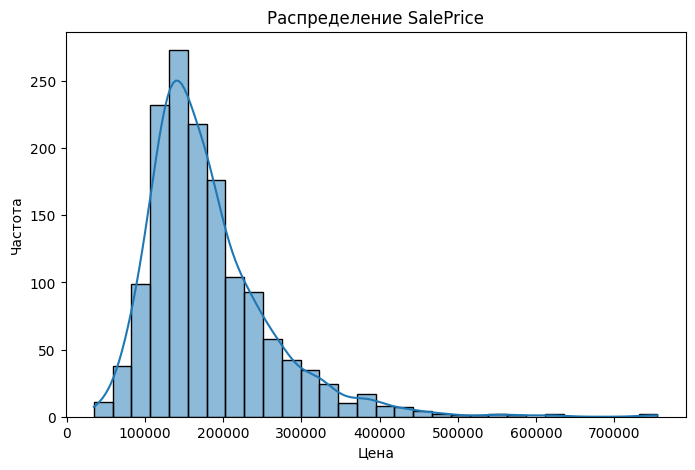

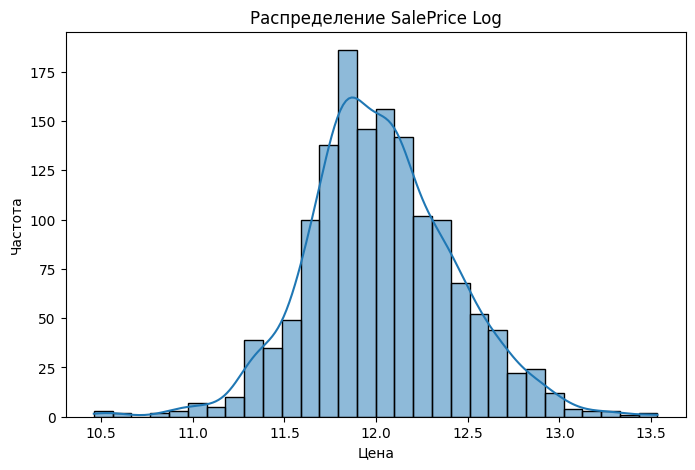

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Построение гистограммы цены
plt.figure(figsize=(8, 5))
sns.histplot(train["SalePrice"], bins=30, kde=True)
plt.title("Распределение SalePrice")
plt.xlabel("Цена")
plt.ylabel("Частота")
plt.show()


gr = train["SalePrice"]
gr = np.log1p(gr)
plt.figure(figsize=(8, 5))
sns.histplot(gr, bins=30, kde=True)

plt.title("Распределение SalePrice Log")
plt.xlabel("Цена")
plt.ylabel("Частота")
plt.show()


In [34]:
df = df.drop(columns=["Id", "Alley", "PoolQC", "Fence", "MiscFeature", "MoSold", "3SsnPorch",
                      "BsmtFinSF2", "BsmtHalfBath", "MiscVal", "LowQualFinSF", "YrSold"]) #убрали то, где много пропусков и низкая корреляция с таргетом до 5 проц


In [35]:
df["MSZoning"] = df.groupby("Neighborhood")["MSZoning"].transform(lambda x: x.fillna(x.mode()[0]))
df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.mode()[0]))
df["Utilities"] = df.groupby("SaleCondition")["Utilities"].transform(lambda x: x.fillna(x.mode()[0]))
df["Exterior1st"] = df.groupby("Neighborhood")["Exterior1st"].transform(lambda x: x.fillna(x.mode()[0]))
df["Exterior2nd"] = df.groupby("Neighborhood")["Exterior2nd"].transform(lambda x: x.fillna(x.mode()[0]))
df.loc[df["MasVnrType"].isnull(), "MasVnrType"] = "None"
df["MasVnrArea"] = df.groupby("LotFrontage")["MasVnrArea"].transform(lambda x: x.fillna(x.mean()))
df.loc[df["BsmtQual"].isnull(), "BsmtQual"] = "Na"
df.loc[df["BsmtCond"].isnull(), "BsmtCond"] = "Na"
df.loc[df["BsmtExposure"].isnull(), "BsmtExposure"] = "Na"
df.loc[df["BsmtFinType1"].isnull(), "BsmtFinType1"] = "Na"
df['BsmtFinSF1'] = df['BsmtFinSF1'].fillna(0)
df["BsmtFinType2"] = df.groupby("BsmtCond")["BsmtFinType2"].transform(lambda x: x.fillna(x.mode()[0]))
df["BsmtUnfSF"] = df["BsmtUnfSF"].transform(lambda x: x.fillna(x.mean()))
df["TotalBsmtSF"] = df.groupby("Neighborhood")["TotalBsmtSF"].transform(lambda x: x.fillna(x.mode()[0]))
df["Electrical"] = df["Electrical"].transform(lambda x: x.fillna(x.mode()[0]))
df["BsmtFullBath"] = df["BsmtFullBath"].transform(lambda x: x.fillna(x.mode()[0]))
df["KitchenQual"] = df.groupby("Neighborhood")["KitchenQual"].transform(lambda x: x.fillna(x.mode()[0]))
df["Functional"] = df["Functional"].transform(lambda x: x.fillna(x.mode()[0]))
df['FireplaceQu'] = df['FireplaceQu'].fillna("Na")
df['GarageType'] = df['GarageType'].fillna("Na")
df["GarageYrBlt"] = df.groupby("Neighborhood")["GarageYrBlt"].transform(lambda x: x.fillna(x.mean()))
df['GarageFinish'] = df['GarageFinish'].fillna("Na")
df['GarageCars'] = df['GarageCars'].fillna(0)
df["GarageArea"] = df["GarageArea"].transform(lambda x: x.fillna(x.mean()))
df['GarageQual'] = df['GarageQual'].fillna("Na")
df['GarageCond'] = df['GarageCond'].fillna("Na")
df["SaleType"] = df["SaleType"].transform(lambda x: x.fillna(x.mode()[0]))

In [36]:
street = {'Grvl': 0, 'Pave': 1} #кодировка признаков - меняем данные на кодировку цифрами
df['Street'] = df['Street'].map(street)
lotshape = {'IR3': 0, 'IR2': 1, 'IR1': 2, 'Reg': 3}
df['LotShape'] = df['LotShape'].map(lotshape)
landcontrol = {'HLS': 0, 'Bnk': 1, 'Low': 2, 'Lvl': 3}
df['LandContour'] = df['LandContour'].map(landcontrol)
utilites = {'NoSeWa': 0, 'AllPub': 1}
df['Utilities'] = df['Utilities'].map(utilites)
landslope = {'Sev': 0, 'Mod': 1, 'Gtl': 2}
df['LandSlope'] = df['LandSlope'].map(landslope)
manstype = {'None': 0, 'BrkCmn': 1, 'Stone': 2, 'BrkFace': 3}
df['MasVnrType'] = df['MasVnrType'].map(manstype)
extra = {'Fa': 0, 'TA': 1, 'Gd': 2, 'Ex': 3}
df['ExterQual'] = df['ExterQual'].map(extra)
extracond = {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
df['ExterCond'] = df['ExterCond'].map(extracond)
fundament = {'Wood': 0, 'Stone': 1, 'CBlock': 2, 'BrkTil': 3, 'PConc': 4, 'Slab':5}
df['Foundation'] = df['Foundation'].map(fundament)
bsmt = {'Na': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
df['BsmtQual'] = df['BsmtQual'].map(bsmt)
bsmtcond = {'Na': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4}
df['BsmtCond'] = df['BsmtCond'].map(bsmtcond)
bsmtexp = {'Na': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}
df['BsmtExposure'] = df['BsmtExposure'].map(bsmtexp)
BsmtFin = {'Na': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4,'ALQ':5, 'GLQ':6}
df['BsmtFinType1'] = df['BsmtFinType1'].map(BsmtFin)
BsmtFin2 = {'Unf': 0, 'LwQ': 1, 'Rec': 2, 'BLQ': 3, 'ALQ': 4,'GLQ':5}
df['BsmtFinType2'] = df['BsmtFinType2'].map(BsmtFin2)
heatingqs = {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
df['HeatingQC'] = df['HeatingQC'].map(heatingqs)
air = {'N': 0, 'Y': 1}
df['CentralAir'] = df['CentralAir'].map(air)
Kitchen = {'Fa': 0, 'TA': 1, 'Gd': 2, 'Ex': 3}
df['KitchenQual'] = df['KitchenQual'].map(Kitchen)
fire = {'Na': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd':4, 'Ex':5}
df['FireplaceQu'] = df['FireplaceQu'].map(fire)
garage = {'Na': 0, 'Detchd': 1, 'CarPort': 2, 'BuiltIn': 3, 'Basment':4, 'Attchd':5, '2Types':6}
df['GarageType'] = df['GarageType'].map(garage)
garage2 = {'Na': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}
df['GarageFinish'] = df['GarageFinish'].map(garage2)
garage3 = {'Na': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd':4, 'Ex':5}
df['GarageQual'] = df['GarageQual'].map(garage3)
df['GarageCond'] = df['GarageCond'].map(garage3)
paved = {'N': 0, 'P': 1, 'Y': 2}
df['PavedDrive'] = df['PavedDrive'].map(paved)

In [38]:
standard_scaler_columns = ['MSSubClass','LotFrontage','YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1', 'TotalBsmtSF',
                           'GrLivArea','GarageYrBlt', 'GarageArea','ScreenPorch','EnclosedPorch','PoolArea']
RobustScaler_columns = ['LotArea','BsmtUnfSF','1stFlrSF', '2ndFlrSF','WoodDeckSF','OpenPorchSF'] #у нас есть колонки с цифрами, мы решили применять стандарт и робуст скаллер, потому что робуст скаллер лучше работает с выбросами, мы и применили его для колонок с большим количеством выбросов

In [39]:
my_scaler = ColumnTransformer( #создаем экземпляр класса колумн трансформер (май скаллер), затем применяем нужный скаллер к соответствующим колонкам
 [
        ('standard_scaler', StandardScaler(), standard_scaler_columns),
        ('RobustScaler', RobustScaler(), RobustScaler_columns),
    ],
    verbose_feature_names_out = False, #оставляем колонки с тем же названием
    remainder = 'passthrough') #все столбцы, к которым не применены стандарт скаллер и робуст скаллер, возвращаются без изменений

In [40]:
df = my_scaler.fit_transform(df) #датафрейм изменяем, проводя нормировку данных (см 2 ячейки выше)

In [43]:
y = train["SalePrice"] #взяли наш таргет
y = np.log1p(y) #устойчив к нулям и малым значениям, лучше работает при обработке данных цен, платежей продаж

#X_train, X_val, y_train, y_val = train_test_split(df.iloc[:len(train)], y, test_size=0.2, random_state=42) #делим выборку 80 на 20, мы можем это сделать только с выборкой трайн (берет до длины датафрейма трэйн)
test = df.iloc[len(train):] #возвращает тест в исходное положение, обратно разделяет
test = test.drop('SalePrice', axis=1)
test

,MSSubClass,LotFrontage,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,TotalBsmtSF,GrLivArea,GarageYrBlt,GarageArea,ScreenPorch,EnclosedPorch,PoolArea,LotArea,BsmtUnfSF,1stFlrSF,2ndFlrSF,WoodDeckSF,OpenPorchSF,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,-0.873616,0.498496,-0.340510,-1.113625,-0.572131,0.058675,-0.384975,-1.195262,-0.637430,1.194149,1.850256,-0.359601,-0.06315,0.530059,-0.336752,-0.363636,0.000000,0.833333,-0.371429,RH,1,3,3,1,Inside,2,NAmes,Feedr,Norm,1Fam,1Story,5,6,Gable,CompShg,VinylSd,VinylSd,0,1,2,2,2,3,1,3,1,GasA,2,1,SBrkr,0.0,1,0,2,1,1,5,Typ,0,0,5,1,1.0,3,3,2,WD,Normal
1,-0.873616,0.544112,-0.439565,-1.257229,0.032284,1.057516,0.629386,-0.339470,-0.755694,-0.747138,-0.285935,-0.359601,-0.06315,1.176442,-0.104274,0.482893,0.000000,2.339286,0.142857,RL,1,2,3,1,Corner,2,NAmes,Norm,Norm,1Fam,1Story,6,6,Hip,CompShg,Wd Sdng,Wd Sdng,3,1,2,2,2,3,1,5,0,GasA,2,1,SBrkr,0.0,1,1,3,1,2,6,Typ,0,0,5,1,1.0,3,3,2,WD,Normal
2,0.067331,0.224799,0.848148,0.657493,-0.572131,0.767742,-0.280589,0.253457,0.781738,0.042381,-0.285935,-0.359601,-0.06315,1.069648,-0.564103,-0.301075,0.995739,1.261905,0.114286,RL,1,2,3,1,Inside,2,Gilbert,Norm,Norm,1Fam,2Story,5,5,Gable,CompShg,VinylSd,VinylSd,0,1,2,4,3,3,1,6,0,GasA,3,1,SBrkr,0.0,2,1,3,1,1,6,Typ,1,3,5,3,2.0,3,3,2,WD,Normal
3,0.067331,0.407263,0.881166,0.657493,-0.460202,0.352839,-0.285127,0.204046,0.821159,-0.013350,-0.285935,-0.359601,-0.06315,0.128299,-0.244444,-0.304985,0.963068,2.142857,0.142857,RL,1,2,3,1,Inside,2,Gilbert,Norm,Norm,1Fam,2Story,6,6,Gable,CompShg,VinylSd,VinylSd,3,1,2,4,2,3,1,6,0,GasA,4,1,SBrkr,0.0,2,1,3,1,2,7,Typ,1,4,5,3,2.0,3,3,2,WD,Normal
4,1.478753,-1.189301,0.683057,0.370284,-0.572131,-0.391353,0.518192,-0.436315,0.584631,0.153842,2.277494,-0.359601,-0.06315,-1.086999,0.940171,0.387097,0.000000,0.000000,0.800000,RL,1,2,0,1,Inside,2,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,Gable,CompShg,HdBoard,HdBoard,0,2,2,4,3,3,1,5,0,GasA,4,1,SBrkr,0.0,2,0,2,1,2,5,Typ,0,0,5,2,2.0,3,3,2,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.419700,-2.192856,-0.043346,-0.682812,-0.572131,-0.968705,-1.147448,-0.807883,-0.158067,-2.196138,-0.285935,-0.359601,-0.06315,-1.836999,0.135043,-1.047898,0.775568,0.000000,-0.371429,RM,1,3,3,1,Inside,2,MeadowV,Norm,Norm,Twnhs,2Story,4,7,Gable,CompShg,CemntBd,CmentBd,0,1,2,2,2,3,1,1,0,GasA,3,1,SBrkr,0.0,1,1,3,1,1,5,Typ,0,0,0,0,0.0,0,0,2,WD,Normal
1455,2.419700,-2.192856,-0.043346,-0.682812,-0.572131,-0.415500,-1.147448,-0.807883,-0.282638,-0.867888,-0.285935,-0.359601,-0.06315,-1.847263,-0.295726,-1.047898,0.775568,0.000000,-0.028571,RM,1,3,3,1,Inside,2,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,Gable,CompShg,CemntBd,CmentBd,0,1,2,2,2,3,1,3,0,GasA,2,1,SBrkr,0.0,1,1,3,1,1,6,Typ,0,0,2,1,1.0,3,3,2,WD,Abnorml
1456,-0.873616,4.147786,-0.373528,0.561757,-0.572131,1.718287,0.391114,-0.546995,-0.676851,0.478938,-0.285935,-0.359601,-0.06315,2.577468,-0.798291,0.277615,0.000000,2.821429,-0.371429,RL,1,3,3,1,Inside,2,Mitchel,Norm,Norm,1Fam,1Story,5,7,Gable,CompShg,VinylSd,VinylSd,0,1,2,2,2,3,1,5,0,GasA,4,1,SBrkr,1.0,1,0,4,1,1,7,Typ,1,3,1,1,2.0,3,3,2,WD,Abnorml
1457,0.655424,-0.322595,0.683057,0.370284,-0.572131,-0.228904,-0.316897,-1.049006,0.211616,-2.196138,-0.285935,-0.359601,-0.06315,0.241447,0.184615,-0.218964,0.000000,0.476190,0.085714,RL,1

In [44]:
train_x = df.iloc[:len(train)]

categorical_features = df.select_dtypes(include=['object']).columns.tolist() #осформировать список из названия колонок, содержащие данные тип данных - объект из этого датафрейма, список сохраняем в эту переменную
train_x = train_x.drop('SalePrice', axis=1)


In [ ]:
#стади - экземпляр класса. креэйт стади - метод, который запускает обучение. дирекшион - мы хотим минимизировать нашу РМЛСЕ
#стади оптимайз - запускает процесс оптимизации наших параметров с помощью функции обджектив, эн трэйлз - это число попыток
#в функции перебираем, подбираем оптимальные параметры


def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 500, 1500, step=500),
        "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.08, step=0.01),
        "depth": trial.suggest_int("depth", 4, 10, step=2),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 7, step=2),
        "task_type": "GPU",
        "verbose": 0
    }
    model = CatBoostRegressor(**params, cat_features=categorical_features) #какую модель маш обуч мы используем, какие параметры передаем
    scores = cross_val_score(model, train_x, y, cv=3, scoring="neg_root_mean_squared_error") #ВОТ ТУТ! ЗДЕСЬ! КРОСС-ВАЛИДАЦИЯ. ОНА БЫЛА ЗДЕСЬ СО ВЧЕРА! cv3 - проводит 3 фолда
    return -scores.mean() #возвращает отрицательное значение РЛМСЕ - это так работает библиотека скайлерн, поэтому ставим - . Выдает среднее по 3м испытаниям

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

best_params = study.best_params #возвращает лучшие параметры
print("Лучшие параметры:", best_params)

# Обучение модели
best_model = CatBoostRegressor(**best_params, verbose=200, cat_features=categorical_features) #создаем экземпляр класса бэст модал (класс катбуст), включаем в него бэст парамс, сат фичес - вводим, если отдельно не обрабатывали категориальные данные
best_model.fit(train_x, y, early_stopping_rounds=100) #y - обучаем модель, логарифмированный таргет, ёрли стоппинг раундс - если за 100 итераций метрика не улучшается, мы останавливаем обучение


#val_preds = best_model.predict(test) #предсказание
#val_preds = np.expm1(val_preds) #
#y_val = np.expm1(y_val)

test_preds = best_model.predict(test) #предиктим тест, применяем нашу обученную модель для предсказания на тестовой выборке
test_preds = np.expm1(test_preds) #экспонента -1. содержит логарифмические предсказания, мы делаем обратные преобразования для тестовой выборки
submission = pd.DataFrame({"Id": test_id["Id"], "SalePrice": test_preds}) #
submission.to_csv("submission777.csv", index=False)

rmse = np.sqrt(mean_squared_error(y_val, val_preds))
print("Validation RMSE:", rmse)

# Предсказание на test
#test_preds = best_model.predict(df.iloc[len(train):])
#test_preds = np.expm1(test_preds)



[I 2025-03-14 10:54:39,159] A new study created in memory with name: no-name-8fefa48d-14a3-4a5b-b888-bff43d3de93b
[I 2025-03-14 10:55:11,297] Trial 0 finished with value: 0.13936454422040853 and parameters: {'iterations': 500, 'learning_rate': 0.02, 'depth': 4, 'l2_leaf_reg': 7}. Best is trial 0 with value: 0.13936454422040853.
[I 2025-03-14 10:58:11,593] Trial 1 finished with value: 0.13162754807504556 and parameters: {'iterations': 1000, 'learning_rate': 0.04, 'depth': 6, 'l2_leaf_reg': 7}. Best is trial 1 with value: 0.13162754807504556.
[I 2025-03-14 11:00:01,105] Trial 2 finished with value: 0.1293190226207969 and parameters: {'iterations': 1000, 'learning_rate': 0.08, 'depth': 4, 'l2_leaf_reg': 1}. Best is trial 2 with value: 0.1293190226207969.
[I 2025-03-14 11:02:55,036] Trial 3 finished with value: 0.13081706492378972 and parameters: {'iterations': 1500, 'learning_rate': 0.04, 'depth': 4, 'l2_leaf_reg': 5}. Best is trial 2 with value: 0.1293190226207969.
[I 2025-03-14 11:05:36

Лучшие параметры: {'iterations': 1500, 'learning_rate': 0.07, 'depth': 4, 'l2_leaf_reg': 1}
0:	learn: 0.3812491	total: 13.5ms	remaining: 20.2s
200:	learn: 0.0947289	total: 2.8s	remaining: 18.1s
400:	learn: 0.0772115	total: 5.64s	remaining: 15.5s
600:	learn: 0.0654612	total: 8.48s	remaining: 12.7s
800:	learn: 0.0564304	total: 11.5s	remaining: 10s
1000:	learn: 0.0499903	total: 14.4s	remaining: 7.19s
1200:	learn: 0.0446128	total: 17.2s	remaining: 4.29s
1400:	learn: 0.0400117	total: 20s	remaining: 1.41s
1499:	learn: 0.0383308	total: 21.4s	remaining: 0us
Validation RMSE: 9020.209685292712


In [45]:
model = CatBoostRegressor(cat_features=categorical_features,
                          iterations=1500, learning_rate=0.06, depth=6, l2_leaf_reg=1)
model.fit(train_x, y)
test_preds = model.predict(test)
test_preds = np.expm1(test_preds)

0:	learn: 0.3827550	total: 63ms	remaining: 1m 34s
1:	learn: 0.3681225	total: 76.2ms	remaining: 57.1s
2:	learn: 0.3537184	total: 88.1ms	remaining: 44s
3:	learn: 0.3400506	total: 102ms	remaining: 38.1s
4:	learn: 0.3269575	total: 115ms	remaining: 34.3s
5:	learn: 0.3158640	total: 127ms	remaining: 31.6s
6:	learn: 0.3049178	total: 138ms	remaining: 29.5s
7:	learn: 0.2949397	total: 151ms	remaining: 28.2s
8:	learn: 0.2846009	total: 164ms	remaining: 27.1s
9:	learn: 0.2753352	total: 177ms	remaining: 26.3s
10:	learn: 0.2656453	total: 187ms	remaining: 25.3s
11:	learn: 0.2576753	total: 199ms	remaining: 24.7s
12:	learn: 0.2493043	total: 210ms	remaining: 24s
13:	learn: 0.2424428	total: 222ms	remaining: 23.5s
14:	learn: 0.2358138	total: 233ms	remaining: 23.1s
15:	learn: 0.2289775	total: 245ms	remaining: 22.7s
16:	learn: 0.2229169	total: 257ms	remaining: 22.4s
17:	learn: 0.2178341	total: 270ms	remaining: 22.2s
18:	learn: 0.2121099	total: 285ms	remaining: 22.2s
19:	learn: 0.2074111	total: 297ms	remaining

In [46]:

# Создание submission-файла для Kaggle
submission = pd.DataFrame({"Id": test_id["Id"], "SalePrice": test_preds})
submission.to_csv("submission.csv", index=False)
print("Файл submission.csv успешно создан!")


Файл submission.csv успешно создан!
